In [1]:
# %cd /home/skyworker/result/4DGS_SlotAttention/slot_4dgs/movi_a_test_04_16_gs_color_compete_full_texture
%cd /home/skyworker/result/4DGS_SlotAttention/slot_4dgs/movi_a_test_04_30_pos_col_encode_decode_triplane_3
!pwd

/data/skyworker/result/4DGS_SlotAttention/slot_4dgs/movi_a_test_04_30_pos_col_encode_decode_triplane_3
/data/skyworker/result/4DGS_SlotAttention/slot_4dgs/movi_a_test_04_30_pos_col_encode_decode_triplane_3


In [2]:
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from PIL import Image as Image
import cv2

In [3]:
from model import *
from dataset import *

# Load YAML.
cfg = OmegaConf.load('config.yaml')
cfg.attention.num_slots = 10

# Get CFG
seed = cfg.training.seed
batch_size = cfg.training.batch_size
num_slots = cfg.attention.num_slots
num_iters = cfg.attention.num_iters
resolution = tuple(cfg.dataset.resolution)

# Set target frame.
frame = 5

# Load val dataset.
val_dir = '/home/skyworker/result/4DGS_SlotAttention/shape_of_motion/'
val_seq = 'movi_a_0053_anoMask'
test_set = ShapeOfMotion(os.path.join(val_dir,val_seq), cfg.dataset)

# Load model.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SlotAttentionAutoEncoder(cfg.dataset, cfg.cnn, cfg.attention).to(device)
model.load_state_dict(torch.load(os.path.join('checkpoints','last.ckpt' ))['model_state_dict'])

# Inference.
model = model.to(device)
sample = test_set[frame]
image = sample['gt_imgs'].to(device)
image = image.squeeze(0)[:,:,:3]
image = image.cpu().detach().numpy()

if cfg.attention.use_all_gs:
    selected = [k for k, m in zip(sample['all_gs'], sample['feature_mask']) if m]
    gs = torch.cat(selected, dim=-1)
else:
    gs = sample['fg_gs']
    # pos_embed = sample['fg_gs_pos']
    

Ks = sample['Ks']
w2cs = sample['w2cs']
gs = gs[None].to(device)
Ks = Ks[None].to(device)
w2cs = w2cs[None].to(device)
pos_embed = sample['all_gs'][0][None].to(device)
print(gs.shape)

torch.Size([1, 27675, 14])


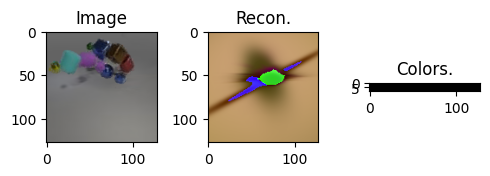

In [4]:
recon_combined,recon_slots,color_code,gs,gs_slot,_ = model(gs, pos_embed, Ks=Ks, w2cs=w2cs,inference=True)
# Squeeze.
recon_combined = (recon_combined * 255).squeeze(0).to(torch.uint8)
recon_slots = (recon_slots * 255)
color_code = (color_code - color_code.min()) / (color_code.max()-color_code.min()) # Min-Max Norm
# color_code = torch.sigmoid(color_code)
color_code = (color_code[:,:,:10,:] * 255).squeeze(0).to(torch.uint8)
color_code = color_code.permute(1,0,2)
# recons = recons.squeeze(0)
# masks = masks.squeeze(0)

# Convert to numpy.
recon_combined = recon_combined.cpu().detach().numpy()
color_code = color_code.cpu().detach().numpy()

fig, ax = plt.subplots(1, 3, figsize=(5, 2))
# plt.imshow(image, cmap='gray')
ax[0].imshow(image)
ax[0].set_title('Image')
ax[1].imshow(recon_combined)
ax[1].set_title('Recon.')
ax[2].imshow(color_code)
ax[2].set_title('Colors.')
plt.tight_layout()

os.makedirs('render', exist_ok=True)

plt.savefig(f'render/{val_seq}_Recon_PLT.png')

# imageio.imwrite('render/0_image.png', (image*255).astype(np.uint8))
# imageio.imwrite('render/1_recon_combined.png', recon_combined)
# color_code = cv2.resize(color_code, (resolution[0], resolution[1]), interpolation=cv2.INTER_NEAREST)
# imageio.imwrite('render/2_color_code.png', color_code)

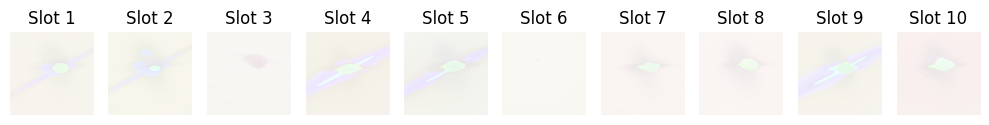

In [5]:
fig, ax = plt.subplots(1, num_slots, figsize=(10, 2))
stack = np.zeros((resolution[0], resolution[1], 4), dtype=np.uint8)
for i in range(num_slots):
  slot = recon_slots[i].squeeze(0).to(torch.uint8)
  picture = slot.cpu().detach().numpy()
  stack += picture
  # picture = recons[i] * masks[i] + (1 - masks[i])
  ax[i].imshow(picture)
  ax[i].set_title('Slot %s' % str(i + 1))
  # imageio.imwrite(f'render/3_slot_{i}.png', picture)
  # imageio.imwrite(f'render/3_slot_alpha_{i}.png', picture)
for i in range(len(ax)):
  ax[i].grid(False)
  ax[i].axis('off')
# ax[num_slots].imshow(stack)
# ax[num_slots].set_title('Slot Stack')
plt.tight_layout()
plt.savefig(f'render/{val_seq}_Slot_{cfg.attention.num_slots}_PLT.png')

In [6]:
# from gsplat.distributed import cli
# from simple_viewer import viewer
# from argparse import Namespace
# slot_num = 1
# out_slot = gs_slot[0][slot_num]
# out_slot = out_slot[:,:14]
# out_slot[:,10] = gs_slot[0,slot_num,:,14]
# args = Namespace(
#     port=8080,
#     gs = out_slot.detach().cpu()
# )

# viewer(args)

In [7]:
!tensorboard --logdir=logs

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.19.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C
